# Lab: Regression

### Import Libraries and Load Data

In [38]:

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


### Load and Clean Dataset

In [39]:
# Define the column names based on auto-mpg.names
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", 
           "acceleration", "model_year", "origin", "car_name"]

# Load the original data file, which may contain missing values or irregularities
data_path = 'auto-mpg.data-original' 
data = pd.read_csv(data_path, names=columns, delim_whitespace=True)

# Drop duplicate rows
data = data.drop_duplicates()

# Separate numeric and non-numeric columns
numeric_data = data.select_dtypes(include='number')  # Numeric columns only
# non_numeric_data = data.select_dtypes(exclude='number')  # Non-numeric columns

# Impute missing values in numeric columns
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

# Recombine numeric and non-numeric data
# data_imputed = pd.concat([numeric_data_imputed, non_numeric_data.reset_index(drop=True)], axis=1)

# Display the first few rows to verify
data_imputed.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


### Exploratory Data Analysis (EDA)

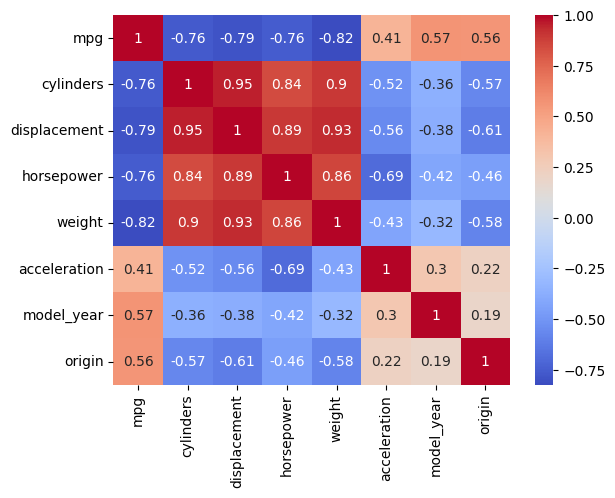

Feature correlations with the target: mpg             1.000000
model_year      0.565698
origin          0.561059
acceleration    0.409338
horsepower     -0.758059
cylinders      -0.762698
displacement   -0.791268
weight         -0.823327
Name: mpg, dtype: float64


In [40]:

# Analyzing feature correlations
corr = data_imputed.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# Display correlation of each feature with the target variable
target = 'mpg'
correlations = corr[target].sort_values(ascending=False)
print("Feature correlations with the target:", correlations)


### Model Selection and Training

In [41]:

# Splitting dataset into features (X) and target (y)
X = data_imputed.drop(columns=[target])  # Drop target column from features
y = data_imputed[target]  # Target variable (mpg in this case)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining models and hyperparameter grids
models = {
    'LinearRegression': (LinearRegression(), {}),
    'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
    'Lasso': (Lasso(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
    'KNN': (KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    'DecisionTree': (DecisionTreeRegressor(), {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
    })
}

# Training models with GridSearchCV
best_models = {}
for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=5, scoring='r2')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_}")



LinearRegression best params: {}
Ridge best params: {'alpha': 10}
Lasso best params: {'alpha': 0.01}
KNN best params: {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
DecisionTree best params: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 5}


### Model Evaluation

In [42]:

# Evaluating models
r2_scores = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2_scores[name] = r2_score(y_test, y_pred)
    print(f"{name} R² Score: {r2_scores[name]}")


LinearRegression R² Score: 0.7796452167342875
Ridge R² Score: 0.7813152087630385
Lasso R² Score: 0.7804841526837853
KNN R² Score: 0.6939402723701293
DecisionTree R² Score: 0.7876952282714414


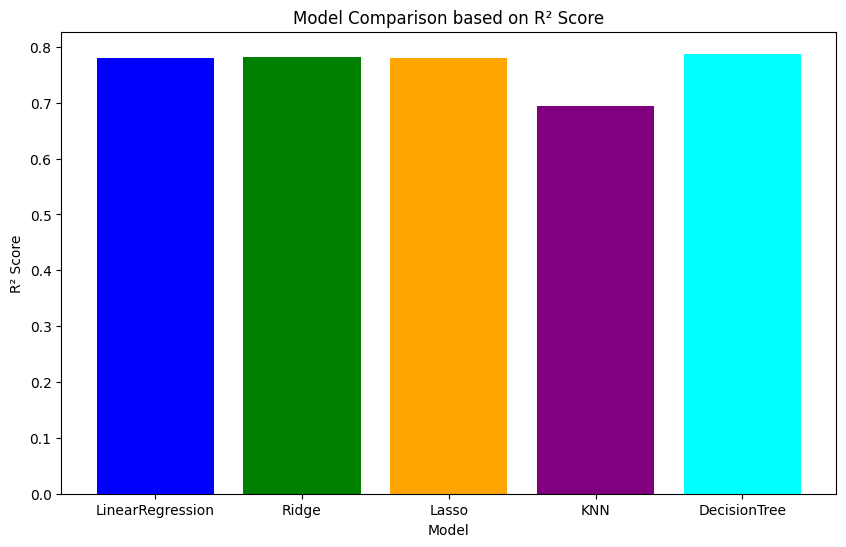

In [43]:

# Plot R² scores for each model
plt.figure(figsize=(10, 6))
plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue', 'green', 'orange', 'purple', 'cyan'])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison based on R² Score')
plt.show()

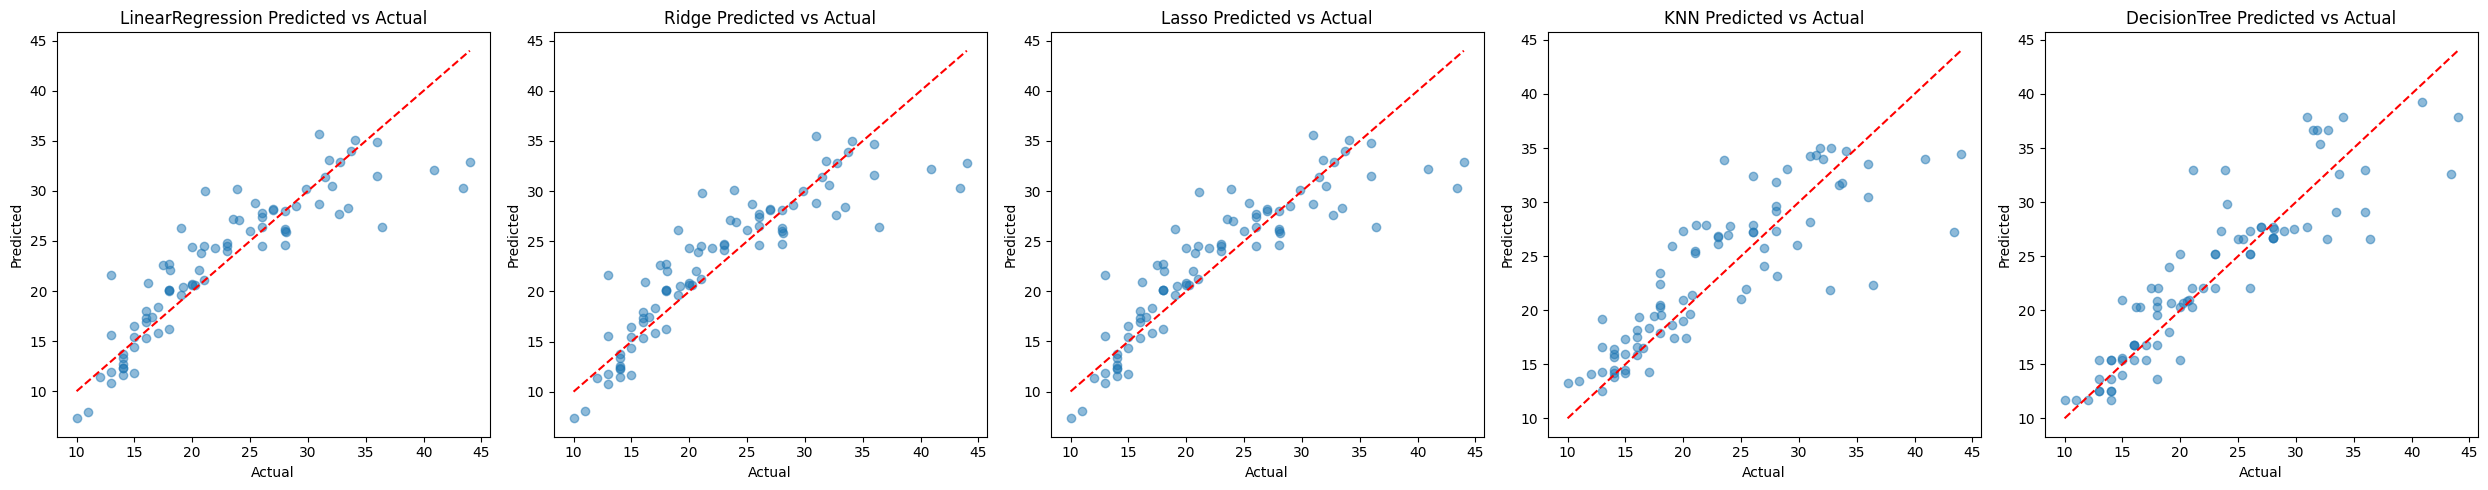

In [ ]:
# Predicted vs. Actual
plt.figure(figsize=(25, 5))
for i, (name, model) in enumerate(best_models.items(), 1):
    y_pred = model.predict(X_test)
    plt.subplot(1, 5, i)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} Predicted vs Actual')
plt.tight_layout()
plt.show()

### Summary Report of Model Performance

In [45]:

# Generating a summary report
report = f"""
Model Evaluation Report
-----------------------
1. Linear Regression:
   - Best Parameters: {best_models['LinearRegression']}
   - R^2 Score: {r2_score(y_test, best_models['LinearRegression'].predict(X_test))}

2. Ridge Regression:
   - Best Parameters: {best_models['Ridge']}
   - R^2 Score: {r2_score(y_test, best_models['Ridge'].predict(X_test))}

3. Lasso Regression:
   - Best Parameters: {best_models['Lasso']}
   - R^2 Score: {r2_score(y_test, best_models['Lasso'].predict(X_test))}

4. KNN Regression:
   - Best Parameters: {best_models['KNN']}
   - R^2 Score: {r2_score(y_test, best_models['KNN'].predict(X_test))}

5. Decision Tree Regression:
   - Best Parameters: {best_models['DecisionTree']}
   - R^2 Score: {r2_score(y_test, best_models['DecisionTree'].predict(X_test))}
"""
print(report)



Model Evaluation Report
-----------------------
1. Linear Regression:
   - Best Parameters: LinearRegression()
   - R^2 Score: 0.7796452167342875

2. Ridge Regression:
   - Best Parameters: Ridge(alpha=10)
   - R^2 Score: 0.7813152087630385

3. Lasso Regression:
   - Best Parameters: Lasso(alpha=0.01)
   - R^2 Score: 0.7804841526837853

4. KNN Regression:
   - Best Parameters: KNeighborsRegressor(n_neighbors=15, p=1, weights='distance')
   - R^2 Score: 0.6939402723701293

5. Decision Tree Regression:
   - Best Parameters: DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=5)
   - R^2 Score: 0.7876952282714414

